# Settings

In [1]:
NB_TESTS_PER_TARGET = 100
MAX_VARIABLE_FOR_BRUTEFORCE = 15

COMPUTE_COMPLEMENTARY = True
DEBUG = False

In [2]:
from pylfit.postprocessing import compute_counterfactuals, bruteforce_counterfactuals
from pylfit.preprocessing.boolean_network import dmvlp_from_boolean_network_file
from pylfit.preprocessing import discrete_state_transitions_dataset_from_array

import random
import time
import pandas
import seaborn as sns
from matplotlib import colors as mcolors

import matplotlib.pyplot as plt

# Compute counterfactual with bruteforce and proposal

In [3]:
benchmarks = [
    "../../benchmarks/boolean_networks/pyboolnet/bio/faure_cellcycle.bnet", 
    "../../benchmarks/boolean_networks/pyboolnet/bio/dinwoodie_life.bnet",
    "../../benchmarks/boolean_networks/pyboolnet/bio/irons_yeast.bnet",
    "../../benchmarks/boolean_networks/pyboolnet/bio/tournier_apoptosis.bnet",
    "../../benchmarks/boolean_networks/pyboolnet/bio/saadatpour_guardcell.bnet",
    "../../benchmarks/boolean_networks/pyboolnet/bio/dahlhaus_neuroplastoma.bnet",
    #"../../benchmarks/boolean_networks/boolenet/budding_yeast.net",
    "../../benchmarks/boolean_networks/boolenet/arabidopsis.net",
    "../../benchmarks/boolean_networks/boolenet/fission_yeast.net",
    "../../benchmarks/boolean_networks/boolenet/thelper.net",
    "../../benchmarks/boolean_networks/boolenet/tcr.net"
    ]

data = []

for bn_file_path in benchmarks:
    print("Loading DMVLP from Boolean network file:", bn_file_path)
    model = dmvlp_from_boolean_network_file(bn_file_path, compute_complementary_rules=COMPUTE_COMPLEMENTARY)
    #model.summary()
    print("variables:", len(model.features))

    # Make the program complete by learning from its transitions
    if not COMPUTE_COMPLEMENTARY:
        print("All states transitions (synchronous): ")
        feature_states = model.feature_states()
        transitions = []
        prediction = model.predict(feature_states, semantics="synchronous", default=[(var,["0"]) for var in model.features])
        for s1 in prediction:
            for s2 in prediction[s1]:
                transitions.append( (s1, s2) )

        print(len(transitions))

        dataset = discrete_state_transitions_dataset_from_array(
        data=transitions,
        feature_names=[var for var,vals in model.features],
        target_names=[var for var,vals in model.targets])

        model.fit(dataset)
        #model.summary()
    
    #model.summary()

    for target_id in range(len(model.targets)):
        
        for test in range(NB_TESTS_PER_TARGET):
            target_name = model.targets[target_id][0]
            s = tuple([random.choice(vals) for var, vals in model.features])
            target_value = [s2 for s2 in model.predict([s])[s]][0][target_id]
            desired_value = "0"
            if target_value == "0":
                desired_value == "1"

            #print(s, target_name, target_value, desired_value)

            if DEBUG:
                solutions = []
                data.append(["Naïve enumeration", bn_file_path, len(model.features), s, target_id, target_value, desired_value, solutions, len(solutions), 2])
                data.append(["CELOS", bn_file_path, len(model.features), s, target_id, target_value, desired_value, solutions, len(solutions), 1])

            else:
                if len(model._features) <= MAX_VARIABLE_FOR_BRUTEFORCE:
                    begin = time.time()
                    solutions = bruteforce_counterfactuals(model, s, target_name, [target_value], [desired_value])[desired_value]
                    run_time = time.time() - begin
                    data.append(["Naïve enumeration", bn_file_path, len(model.features), s, target_id, target_value, desired_value, solutions, len(solutions), run_time])

                begin = time.time()
                solutions = compute_counterfactuals(model, s, target_name, [target_value], [desired_value])[desired_value]
                run_time = time.time() - begin
                data.append(["CELOS", bn_file_path, len(model.features), s, target_id, target_value, desired_value, solutions, len(solutions), run_time])

            #print(solutions)
            #print("\r"+str(test+1)+"/"+str(NB_TESTS_PER_TARGET))
        
df = pandas.DataFrame(data, columns=["method", "file", "variables", "feature_state", "target_id",  "target_value", "desired_value", "solutions", "nb_solutions", "run_time"])
display(df)

Loading DMVLP from Boolean network file: ../../benchmarks/boolean_networks/pyboolnet/bio/faure_cellcycle.bnet
variables: 10
Loading DMVLP from Boolean network file: ../../benchmarks/boolean_networks/pyboolnet/bio/dinwoodie_life.bnet
variables: 15
Loading DMVLP from Boolean network file: ../../benchmarks/boolean_networks/pyboolnet/bio/irons_yeast.bnet
variables: 18
Loading DMVLP from Boolean network file: ../../benchmarks/boolean_networks/pyboolnet/bio/tournier_apoptosis.bnet
variables: 12
Loading DMVLP from Boolean network file: ../../benchmarks/boolean_networks/pyboolnet/bio/saadatpour_guardcell.bnet
variables: 13
Loading DMVLP from Boolean network file: ../../benchmarks/boolean_networks/pyboolnet/bio/dahlhaus_neuroplastoma.bnet
variables: 23
Loading DMVLP from Boolean network file: ../../benchmarks/boolean_networks/boolenet/arabidopsis.net
variables: 15
Loading DMVLP from Boolean network file: ../../benchmarks/boolean_networks/boolenet/fission_yeast.net
variables: 10
Loading DMVLP fr

,method,file,variables,feature_state,target_id,target_value,desired_value,solutions,nb_solutions,run_time
0,Naïve enumeration,../../benchmarks/boolean_networks/pyboolnet/bi...,10,"(1, 0, 1, 0, 0, 0, 0, 1, 0, 1)",0,1,0,[{CycD_t_1(0)}],1,0.017268
1,CELOS,../../benchmarks/boolean_networks/pyboolnet/bi...,10,"(1, 0, 1, 0, 0, 0, 0, 1, 0, 1)",0,1,0,[{CycD_t_1(0)}],1,0.000056
2,Naïve enumeration,../../benchmarks/boolean_networks/pyboolnet/bi...,10,"(0, 1, 1, 1, 0, 1, 0, 0, 0, 1)",0,0,0,[],0,0.000635
3,CELOS,../../benchmarks/boolean_networks/pyboolnet/bi...,10,"(0, 1, 1, 1, 0, 1, 0, 0, 0, 1)",0,0,0,[],0,0.000033
4,Naïve enumeration,../../benchmarks/boolean_networks/pyboolnet/bi...,10,"(1, 0, 1, 0, 0, 0, 0, 1, 0, 0)",0,1,0,[{CycD_t_1(0)}],1,0.015504
...,...,...,...,...,...,...,...,...,...,...
25395,CELOS,../../benchmarks/boolean_networks/boolenet/tcr...,40,"(1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, ...",39,1,0,[{Calcin_t_1(0)}],1,0.000062
25396,CELOS,../../benchmarks/boolean_networks/boolenet/tcr...,40,"(0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, ...",39,1,0,[{Calcin_t_1(0)}],1,0.000062
25397,CELOS,../../benchmarks/boolean_networks/boolenet/tcr...,40,"(1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, ...",39,0,0,[],0,0.000060
25398,CELOS,../../benchmarks/boolean_networks/boolenet/tcr...,40,"(0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, ...",39,0,0,[],0,0.000063


In [4]:
df[df["nb_solutions"]>0]

df.to_csv("results_benchmarks.csv")

# Visualize performance

In [5]:
BRUTE_FORCE_COLOR = mcolors.to_rgba("#C6110B") #"lightcoral"
GULA_COLOR = mcolors.to_rgba("#0B7FF3") #"skyblue"
WHIS_VALUE = 10000000

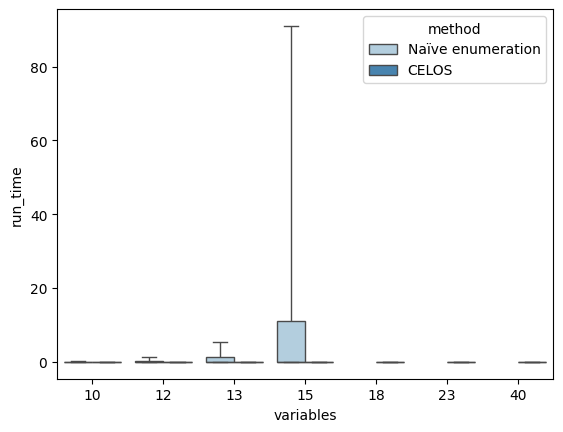

In [6]:
#df_brute_force = df_semantics[df_semantics["method"] == "brute_force"]
ax = sns.boxplot(x="variables", y="run_time", hue="method", data=df,
                #whiskerprops = dict(color=BRUTE_FORCE_COLOR, linewidth=2.0, alpha= 0.8),
                #capprops = dict(color=BRUTE_FORCE_COLOR, linewidth=2.0, alpha= 0.8),
                whis=WHIS_VALUE,
                palette="Blues",
                log_scale=False)

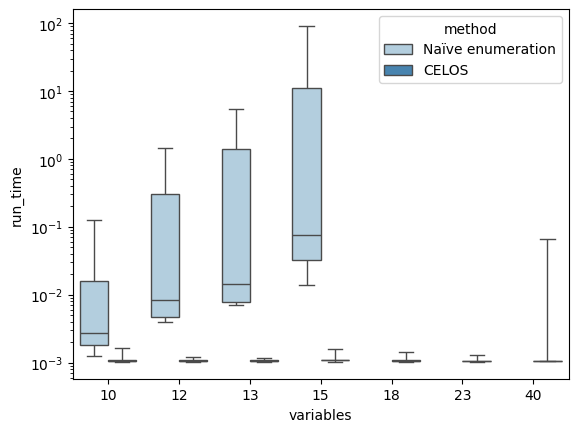

In [7]:
df_tmp = df.copy()
df_tmp["run_time"] += 0.001
ax = sns.boxplot(x="variables", y="run_time", hue="method", data=df_tmp,
                #whiskerprops = dict(color=BRUTE_FORCE_COLOR, linewidth=2.0, alpha= 0.8),
                #capprops = dict(color=BRUTE_FORCE_COLOR, linewidth=2.0, alpha= 0.8),
                whis=WHIS_VALUE,
                palette="Blues",
                log_scale=True)

plt.savefig("bn_benchmarks_run_times.pdf", bbox_inches='tight')